# Analyzing Puerto Rico Earthquake Data

First thing first, lets use the data extracted using the ETL process described in the previous notebook. We will get it from the MySQL database:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from etl import connect_to_db, get_regions
from reporting import extract_eq_data, font
pd.set_option('display.max_rows',2000)

In [3]:
#connect to db 
db = "eq_pr"
user = 'root'
conn = connect_to_db(db, user)

Enter database password:········
Successfull connection to MySQL database


### Get Data

In [21]:
df = extract_eq_data(conn)
# ----
month = datetime.strftime(df.index[1],'%B-%Y')
#-----
daily = df[['mag']].resample('D').count()
daily['min']= df[['mag']].resample('D').min()
daily['max']= df[['mag']].resample('D').max()
daily['mean']= df[['mag']].resample('D').mean()
daily.rename(columns = {'mag':'cnt'}, inplace = True)

# ---- dataframe with stats by seismic region

regions =df[['mag', 'region']].groupby('region').agg({'mag':['count', 'mean','max','min',]})
regions.columns = [x[1] for x in regions.columns.ravel()]
regions = regions.sort_values('count', ascending = False)
regions.reset_index(inplace = True)

#----- get geo data for seismic regions
regions_gdf = get_regions(conn)
regions_gdf['lat'] = regions_gdf.geometry.centroid.y
regions_gdf['lon'] = regions_gdf.geometry.centroid.x

#----- create geojson file --> https://geopandas.org/io.html
regions_gdf.to_file("./data/regions_polys.geojson", driver='GeoJSON')

#----- add centroid to regions for plotting the map

regions = regions.merge(regions_gdf[['Name','lat','lon']], how = 'left', left_on = 'region', right_on = 'Name')
regions.drop(columns = 'Name', inplace = True)

Enter report type ("y" for yearly or "m" for monthly):y
Enter Full Year: 2020


C:\Users\Melissa\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\Melissa\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



 

Overall: 
 
Total event count:  12046 
 
Average Magnitude:  2.56 
 
Highest Magnitude recorded was  6.4 on 2020-01-07 08:24:27 
 
Most active day of the month:  01/07/2020 with 778 events 
 
Least active day of the month:  11/13/2020 with 3 events 


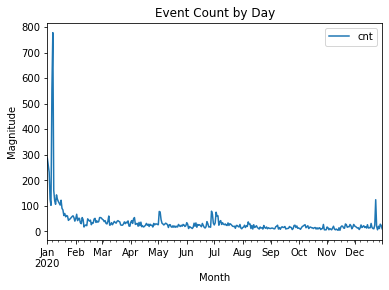

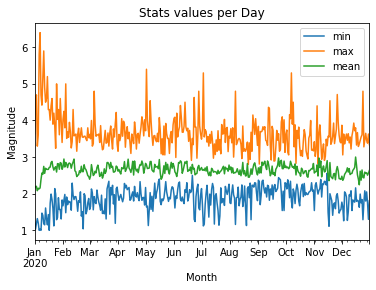

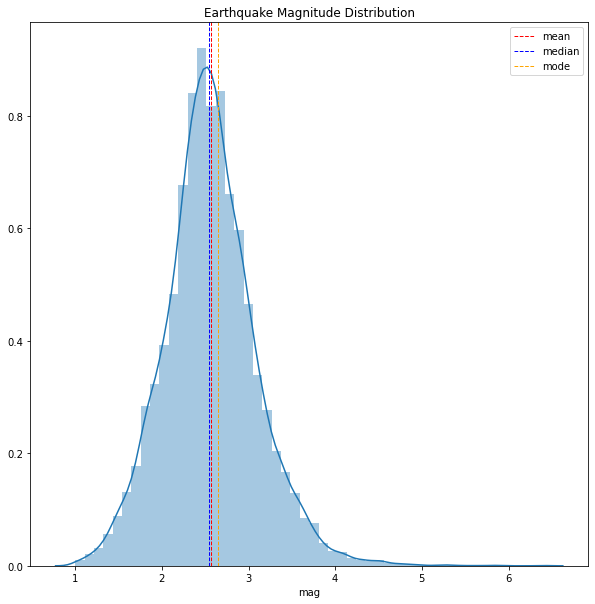

In [22]:
# print(font.BOLD,'\nEvent report for:',font.UNDERLINE,month,font.END)

print(font.BOLD+font.UNDERLINE,'\n\nOverall:',font.END)
print(font.BOLD,'\nTotal event count:',font.UNDERLINE, len(df),font.END)
print(font.BOLD,'\nAverage Magnitude:',font.UNDERLINE, round(df.mag.mean(),2),font.END)
print(font.BOLD,'\nHighest Magnitude recorded was',font.UNDERLINE, df.mag.max(),'on', df.mag.idxmax(),font.END )

print(font.BOLD,'\nMost active day of the month:',
      font.UNDERLINE,datetime.strftime(daily.cnt.idxmax(),'%m/%d/%Y'), 'with', daily.cnt.max(), 'events',font.END)
print(font.BOLD,'\nLeast active day of the month:',
      font.UNDERLINE,datetime.strftime(daily.cnt.idxmin(),'%m/%d/%Y'),
      'with', daily.cnt.min(), 'events',font.END)

daily[['cnt']].plot(title = 'Event Count by Day'
                      ,xlabel = 'Month'
                      ,ylabel = 'Magnitude')
daily[['min', 'max', 'mean']].plot(title = 'Stats values per Day'
                                    ,xlabel = 'Month'
                                    ,ylabel = 'Magnitude');
data = df
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(data.mag, kde=True).set_title('Earthquake Magnitude Distribution')
plt.axvline(data.mag.mean(), color='red', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(data.mag.median(), color='blue', linestyle='dashed', linewidth=1, label = 'median')
plt.axvline(data.mag.mode()[0], color='orange', linestyle='dashed', linewidth=1, label='mode')
plt.legend()
plt.show();



 

Regions: 
 

Most active region of the month was:  Southern Puerto Rico with 6008 events 
 

Least active region of the month was:  Eastern Puerto Rico with 1 events 
 
Highest Magnitude recorded was  6.4 in Southern Puerto Rico on 2020-01-07 08:24:27 


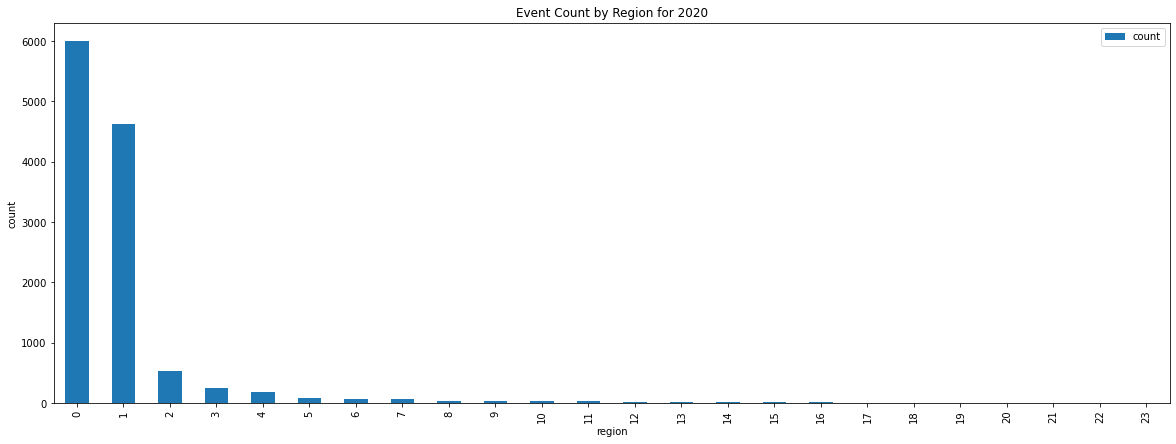

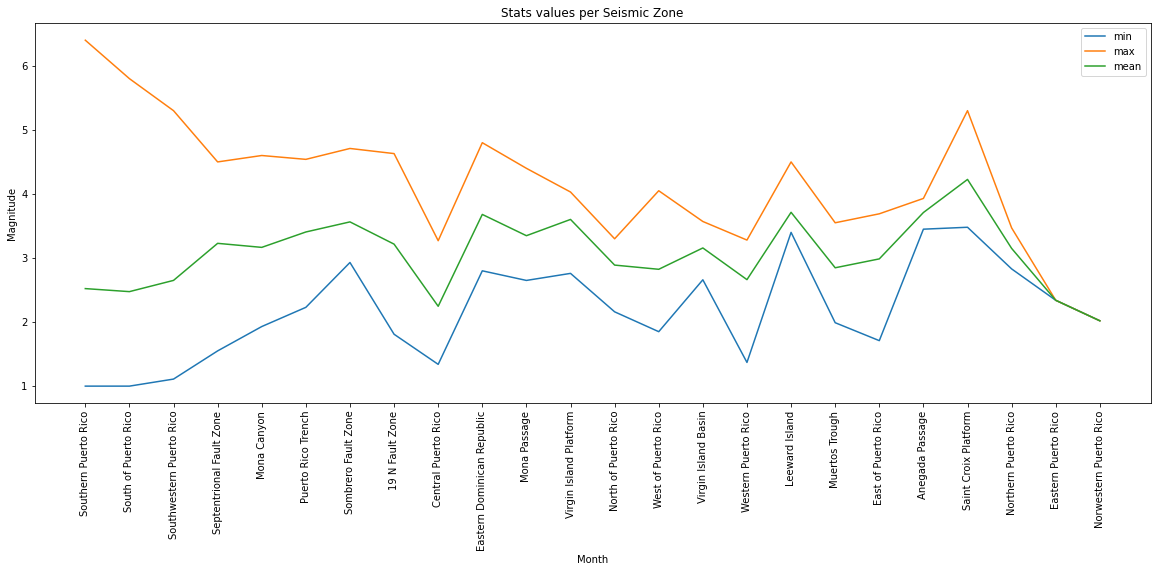

In [23]:
print(font.BOLD+font.UNDERLINE,'\n\nRegions:',font.END)
print(font.BOLD,"\n\nMost active region of the month was:", 
      font.UNDERLINE,regions.iloc[regions['count'].idxmax()][0],
      'with', regions.iloc[regions['count'].idxmax()][1], 'events',font.END)


print(font.BOLD,"\n\nLeast active region of the month was:", 
      font.UNDERLINE,regions.iloc[regions['count'].idxmin()][0],
      'with', regions.iloc[regions['count'].idxmin()][1], 'events',font.END)

print(font.BOLD,'\nHighest Magnitude recorded was', font.UNDERLINE, df.mag.max(),
      'in', df.loc[df.mag == df.mag.max(), 'region'][0],'on',df.mag.idxmax(),font.END )

regions[['count']].plot(title = 'Event Count by Region for 2020'
                        ,kind = 'bar'
                        ,figsize=(20,7)
                        ,xlabel = 'region'
                        ,ylabel = 'count'
                       )                       

regions[['min', 'max', 'mean']].plot(title = 'Stats values per Seismic Zone'
                                    ,kind = 'line'
                                    ,xlabel = 'Month'
                                    ,ylabel = 'Magnitude'
                                    ,figsize=(20,7))


xticks=plt.xticks(regions.index, regions['region'], rotation=90)
plt.show();


In [24]:
#Map for Zone with higest activity
#reference: https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b


data = regions[['region','count','min','max','mean','lat','lon']]
map = folium.Map(location=[18.2208,-66.5901]#Puerto Rico Location
                 ,tiles='CartoDB positron'
                )
map.choropleth(geo_data='./data/regions_polys.geojson'
               ,data=data 
               ,columns=['region','count'] 
               ,key_on='feature.properties.Name'
               ,fill_color='OrRd'
               ,fill_opacity=0.7
               ,line_opacity=0.2
               ,legend_name='Event Count'
               ,bins=9
               ,reset=True
              )
# marker_cluster = MarkerCluster().add_to(map)#create marker cluster
for i in range(0,2):
    location = [data['lat'][i],data['lon'][i]]
    tooltip = "<b>Region: </b>{}<br> <b>Count: </b>{}<br> <b>Maximum Magnitude: </b>{}<br>".format(data["region"][i] , data['count'][i], data['max'][i])
    
    folium.Marker(location # adding more details to the popup screen using HTML
                  ,tooltip=tooltip).add_to(map)
map

C:\Users\Melissa\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [25]:
#Map zone activity
#reference: https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b


data = regions[['region','count','min','max','mean','lat','lon']][3:]
data.reset_index(inplace=True, drop = True)
map = folium.Map(location=[18.2208,-66.5901]#Puerto Rico Location
                 ,tiles='CartoDB positron'
                )
map.choropleth(geo_data='./data/regions_polys.geojson'
               ,data=data 
               ,columns=['region','count'] 
               ,key_on='feature.properties.Name'
               ,fill_color='YlGnBu'
               ,fill_opacity=0.4
               ,line_opacity=0.5
               ,legend_name='Event Count'
#                ,bins=9
               ,reset=True
              )
# marker_cluster = MarkerCluster().add_to(map)#create marker cluster
for i in range(data.shape[0]):
    location = [data['lat'][i],data['lon'][i]]
    tooltip = "<b>Region: </b>{}<br> <b>Count: </b>{}<br> <b>Maximum Magnitude: </b>{}<br>".format(data["region"][i] , data['count'][i], data['max'][i])
    
    folium.Marker(location # adding more details to the popup screen using HTML
                  ,tooltip=tooltip).add_to(map)
map